In [1]:
import numpy as np
import pandas as pd 
import os
import cv2
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

%matplotlib inline

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMG_SIZE = 768

print('Batch size:', BATCH_SIZE)

Running on TPU: grpc://10.0.0.2:8470
Batch size: 64


In [3]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

print(train.head())

train_path = train.image_id.apply(lambda x: f'{GCS_DS_PATH}/images/{x}.jpg').values
test_path = test.image_id.apply(lambda x: f'{GCS_DS_PATH}/images/{x}.jpg').values
train_label = train.loc[:, 'healthy':].values

# train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label,
#                                                                     test_size=0.1, stratify=train_label)

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


<BarContainer object of 4 artists>

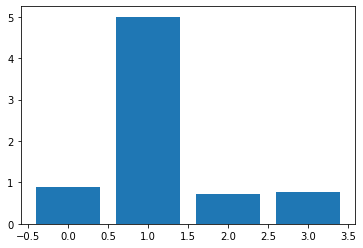

In [4]:
class_weight = compute_class_weight('balanced', np.unique(np.argmax(train_label, axis=1)), np.argmax(train_label, axis=1))
plt.bar(range(4), class_weight)

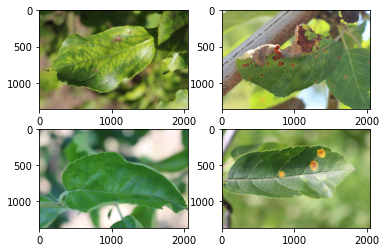

In [5]:
fig, ax = plt.subplots(2, 2)
img = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
img1 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1.jpg')
img2 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_2.jpg')
img3 = cv2.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg')
ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0, 1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[1, 0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1, 1].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

In [6]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [7]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((train_path, train_label))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# valid_dataset = (
#     tf.data.TFRecordDataset
#     .from_tensor_slices((valid_path, valid_label))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment, num_parallel_calls=AUTO)
#     .cache()
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(test_path)
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

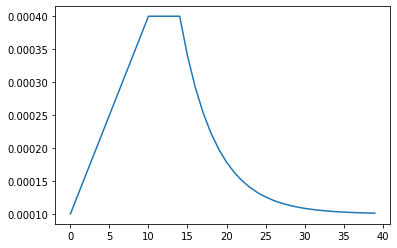

In [8]:
EPOCHS = 40
LR_START = 0.0001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr = tf.keras.callbacks.LearningRateScheduler(lrfn)

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

In [9]:
!pip install -q efficientnet

In [10]:
from efficientnet.tfkeras import EfficientNetB7

with strategy.scope():
    efn = EfficientNetB7(include_top=False, weights='noisy-student', pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(efn)
    model.add(L.Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

258072576/258068648 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________
None


In [11]:
mc = tf.keras.callbacks.ModelCheckpoint('weights.h5', monitor='loss', save_best_only=True, save_weights_only=True)
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[lr, mc], steps_per_epoch=train_label.shape[0] // BATCH_SIZE)

Train for 28 steps
Epoch 1/40
28/28 [==============================] - 372s 13s/step - loss: 1.0572 - accuracy: 0.6194
Epoch 2/40
28/28 [==============================] - 33s 1s/step - loss: 0.5000 - accuracy: 0.8443
Epoch 3/40
28/28 [==============================] - 33s 1s/step - loss: 0.3473 - accuracy: 0.8878
Epoch 4/40
28/28 [==============================] - 33s 1s/step - loss: 0.2644 - accuracy: 0.9146
Epoch 5/40
28/28 [==============================] - 33s 1s/step - loss: 0.2033 - accuracy: 0.9353
Epoch 6/40
28/28 [==============================] - 34s 1s/step - loss: 0.1877 - accuracy: 0.9420
Epoch 7/40
28/28 [==============================] - 34s 1s/step - loss: 0.1585 - accuracy: 0.9420
Epoch 8/40
28/28 [==============================] - 33s 1s/step - loss: 0.1386 - accuracy: 0.9537
Epoch 9/40
28/28 [==============================] - 28s 1s/step - loss: 0.1397 - accuracy: 0.9503
Epoch 10/40
28/28 [==============================] - 34s 1s/step - loss: 0.1333 - accuracy: 0.958

In [12]:
with strategy.scope():
    model.load_weights('weights.h5')
# valid_prob = model.predict(valid_dataset, verbose=1)
# print(metrics.classification_report(np.argmax(valid_label, axis=1), np.argmax(valid_prob, axis=1)))
# print(metrics.confusion_matrix(np.argmax(valid_label, axis=1), np.argmax(valid_prob, axis=1)))

In [13]:
probs = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs
sub.to_csv('submission.csv', index=False)
sub.head()

29/29 [==============================] - 131s 5s/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.074538e-08,2.077582e-05,9.999784e-01,8.133425e-07
1,Test_1,9.290406e-10,1.083848e-06,9.999988e-01,1.366048e-07
2,Test_2,8.047632e-07,2.446295e-06,2.912862e-08,9.999967e-01
3,Test_3,9.999999e-01,1.592484e-09,9.509980e-09,8.014737e-08
4,Test_4,3.225522e-10,6.028464e-08,9.999999e-01,5.987290e-09
